## Understand the Data Structure (EDA)

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz

This cell loads the dataset and provides an initial overview of its structure and contents.

- pd.read_csv(file_path): Reads the dataset into a Pandas DataFrame.
- df.info(): Displays data types, non-null counts, and memory usage to check for missing values and column types.
- df.describe(): Provides summary statistics (mean, min, max, etc.) for numerical columns.
- df.head(): Displays the first few rows to get a sense of the dataset's structure.
---
This step ensures an understanding of the data before preprocessing and modeling.

In [2]:
# Load the dataset
file_path = "paysim1/PS_20174392719_1491204439457_log.csv"
df = pd.read_csv(file_path)

# Overview of the dataset
print(df.info())       # Data types and missing values
print(df.describe())   # Summary statistics
print(df.head())       # First few rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04

This cell performs two key tasks:

1. Renaming Columns:
- The dataset's column names are updated to maintain a consistent naming style, improving readability and usability.
- Example: oldbalanceOrg → oldBalanceOrig, newbalanceOrig → newBalanceOrig.
2. Checking for Missing Values:
- df.isnull().values.any() checks if there are any missing values in the dataset.
3. Previewing the Data:
- df.head() is printed again to confirm that column names have been updated correctly.
---
This step ensures that the dataset is clean and ready for further analysis.

In [ ]:
df = df.rename(columns={'step':'Step', 'type':'Type', 'amount':'Amount', 'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', 'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
df.isnull().values.any()
print(df.head())

   Step      Type    Amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


This cell analyzes the types and counts of fraudulent transactions in the dataset.

1. Identifying Fraudulent Transaction Types:
- Extracts unique transaction types where isFraud == 1.
- Prints the types of fraudulent transactions found.
2. Filtering Fraudulent Transactions:
- dfFraudTransfer: Subset where fraud occurred in TRANSFER transactions.
- dfFraudCashout: Subset where fraud occurred in CASH_OUT transactions.
3. Counting Fraudulent Transactions:
- Prints the number of fraudulent TRANSFER and CASH_OUT transactions.
---
This step provides insight into which transaction types are commonly associated with fraud, aiding feature selection and model training.

In [4]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].Type.drop_duplicates().values))) 

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.Type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.Type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) 
print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) 


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


This cell examines transactions where `isFlaggedFraud` is set to 1, providing insight into how the dataset marks suspicious activities.

1. Identifying Transaction Types with isFlaggedFraud == 1:
- Extracts and prints unique transaction types flagged as fraud.
2. Creating Subsets of the Data:
- dfTransfer: Contains all TRANSFER transactions.
- dfFlagged: Contains transactions where isFlaggedFraud == 1.
- dfNotFlagged: Contains transactions where isFlaggedFraud == 0.
3. Analyzing Flagged Fraud Transactions:
- Finds the minimum transaction amount where isFlaggedFraud is set.
- Finds the maximum transaction amount in TRANSFER transactions where isFlaggedFraud is not set.
---
This step helps understand what triggers the fraud flag and whether high-value transactions are systematically flagged.

In [5]:
print('\nThe Type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].Type.drop_duplicates())))

dfTransfer = df.loc[df.Type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin Amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.Amount.min()))
                                  
print('\nMax Amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].Amount.max()))


The Type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min Amount transacted when isFlaggedFraud is set= 353874.22

Max Amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


This cell investigates potential fraud patterns by examining `TRANSFER` transactions that were **not** flagged as fraudulent but have suspicious balance behavior.  

1. **Filtering Transactions**:  
   - Selects `TRANSFER` transactions where `isFlaggedFraud == 0`.  
   - Further filters cases where both `oldBalanceDest` and `newBalanceDest` are **zero**.  

2. **Counting Suspicious Transactions**:  
   - Prints the number of such transactions.  

### Why This Matters:  
This check helps identify cases where money is supposedly transferred, but the recipient's balance remains unchanged—potentially indicating fraud.  


In [6]:
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and\
 newBalanceDest = 0: {}'.\
format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & \
(dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceDest == 0)])))


The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: 4158


This cell analyzes the `oldBalanceOrig` values for flagged and unflagged `TRANSFER` transactions to detect unusual patterns.  

1. **Examining Flagged Fraud Cases**:  
   - Finds the **minimum and maximum** `oldBalanceOrig` for `TRANSFER` transactions where `isFlaggedFraud == 1`.  
   - This helps understand the balance ranges for transactions that were marked as suspicious.  

2. **Analyzing Unflagged Transactions with No Balance Change**:  
   - Finds the **min and max** `oldBalanceOrig` for `TRANSFER` transactions where `isFlaggedFraud == 0` **and** `oldBalanceOrig == newBalanceOrig`.  
   - This condition checks cases where money was supposedly transferred, yet the sender's balance remained the same—potentially indicating fraudulent activity that was not flagged.  

### Why This Matters:  
By comparing flagged and unflagged transactions, this step helps uncover inconsistencies in the fraud detection logic, which can be useful for refining fraud detection models.  


In [7]:
print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: {}'.\
format([round(dfFlagged.oldBalanceOrig.min()), round(dfFlagged.oldBalanceOrig.max())]))

print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where \
oldBalanceOrig = \
newBalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
== dfTransfer.newBalanceOrig)].oldBalanceOrig.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
               == dfTransfer.newBalanceOrig)].oldBalanceOrig.max())]))


Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: [353874, 19585040]

Min, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig: [0.0, 575668]


This cell investigates the transaction behavior of flagged fraud accounts to detect potential fraud networks.  

1. **Checking if Fraudulent Originators Transacted More Than Once**:  
   - Determines if any `nameOrig` (origin accounts) from flagged fraud transactions also appear in **unflagged** transactions as either an origin (`nameOrig`) or a destination (`nameDest`).  
   - This helps identify whether fraud-flagged users continued to transact outside of flagged cases.  

2. **Checking if Fraudulent Destinations Initiated Other Transactions**:  
   - Determines if any `nameDest` (destination accounts) from flagged fraud transactions later **initiated** transactions (`nameOrig`) in unflagged cases.  
   - This could indicate money laundering or fraudulent fund redistribution.  

3. **Counting Destination Accounts Appearing Multiple Times**:  
   - Counts how many fraud-flagged destination accounts (`nameDest`) have **also been destinations** in other unflagged transactions.  
   - If a flagged destination frequently receives funds, it might be a fraud hub.  

### Why This Matters:  
This analysis helps identify suspicious transaction patterns, such as fraudsters reusing accounts, laundering money, or forming fraud rings.  


In [8]:
print('\nHave originators of transactions flagged as fraud transacted more than \
once? {}'\
.format((dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, \
                                    dfNotFlagged.nameDest]))).any()))

print('\nHave destinations for transactions flagged as fraud initiated\
 other transactions? \
{}'.format((dfFlagged.nameDest.isin(dfNotFlagged.nameOrig)).any()))

print('\nHow many destination accounts of transactions flagged as fraud have been \
destination accounts more than once?: {}'\
.format(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest))))


Have originators of transactions flagged as fraud transacted more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False

How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 2


This cell investigates whether merchants (accounts starting with 'M') are involved in **CASH_IN** and **CASH_OUT** transactions, which could indicate fraud or unusual behavior.  

1. **Checking Merchants as Originators in `CASH_IN` Transactions**:  
   - Looks for accounts starting with 'M' (`nameOrig.str.contains('M')`) among `CASH_IN` transactions.  
   - If `True`, it means merchants are depositing money, which might be unusual since merchants typically receive funds rather than deposit them.  

2. **Checking Merchants as Destinations in `CASH_OUT` Transactions**:  
   - Looks for accounts starting with 'M' (`nameDest.str.contains('M')`) among `CASH_OUT` transactions.  
   - If `True`, it suggests merchants are receiving cash withdrawals, which could be a sign of fraud, money laundering, or an operational quirk of the dataset.  

### Why This Matters:  
This step helps understand whether merchants are behaving as expected in the dataset or if there are anomalies suggesting fraud.  


In [9]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.Type == 'CASH_IN'].nameOrig.str.contains('M')).any()))

print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.Type == 'CASH_OUT'].nameDest.str.contains('M')).any()))


Are there any merchants among originator accounts for CASH_IN transactions? False

Are there any merchants among destination accounts for CASH_OUT transactions? False


In [ ]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.Type == 'CASH_IN'].nameOrig.str.contains('M')).any()))

print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.Type == 'CASH_OUT'].nameDest.str.contains('M')).any()))


Are there any merchants among originator accounts for CASH_IN transactions? False

Are there any merchants among destination accounts for CASH_OUT transactions? False


In [ ]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.Type == 'CASH_IN'].nameOrig.str.contains('M')).any()))

print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.Type == 'CASH_OUT'].nameDest.str.contains('M')).any()))


Are there any merchants among originator accounts for CASH_IN transactions? False

Are there any merchants among destination accounts for CASH_OUT transactions? False


This cell examines the presence of merchants (`nameOrig` or `nameDest` starting with 'M') in transactions to detect unusual patterns.  

1. **Checking if Merchants Are Originators in Any Transaction**:  
   - Searches for any account starting with 'M' in `nameOrig`.  
   - If `True`, it means merchants are initiating transactions, which could be unusual since merchants typically receive payments rather than send them.  

2. **Checking if Merchants Receive Non-`PAYMENT` Transactions**:  
   - Filters transactions where `nameDest` starts with 'M'.  
   - Checks whether these transactions include types **other than** `PAYMENT`.  
   - If `True`, it suggests merchants are receiving funds through unexpected transaction types, which might indicate fraud or irregular financial activity.  

### Why This Matters:  
This helps identify whether merchants are behaving as expected in the dataset or if their accounts are being misused for fraud.  


In [10]:
print('\nAre there merchants among any originator accounts? {}'.format(\
      df.nameOrig.str.contains('M').any()))

print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT Type? {}'.format(\
(df.loc[df.nameDest.str.contains('M')].Type != 'PAYMENT').any()))


Are there merchants among any originator accounts? False

Are there any transactions having merchants among destination accounts other than the PAYMENT Type? False


This cell examines whether fraudulent **TRANSFER** transactions feed directly into fraudulent **CASH_OUT** transactions, which could indicate a common fraud pattern.  

1. **Checking if Fraudulent TRANSFER Destinations Are Also CASH_OUT Originators**:  
   - `dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)` checks if any accounts receiving fraudulent **TRANSFER** transactions later **initiate** fraudulent **CASH_OUT** transactions.  
   - If `True`, it suggests that fraudsters first **transfer** funds to an intermediary account, which then **cashes out** the money—potentially a sign of money laundering or coordinated fraud schemes.  

2. **Creating a Non-Fraudulent Transactions Subset**:  
   - `dfNotFraud = df.loc[df.isFraud == 0]` stores all **legitimate** transactions.  
   - This allows for later comparisons between fraud and non-fraud behaviors.  

### Why This Matters:  
This helps detect potential fraud rings where money is funneled through intermediary accounts before being withdrawn.  

In [11]:
print('\nWithin fraudulent transactions, are there destinations for TRANSFERS \
that are also originators for CASH_OUTs? {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any()))

dfNotFraud = df.loc[df.isFraud == 0]


Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


This cell investigates whether **fraudulent TRANSFERs** are being sent to accounts that later initiate **genuine (non-fraudulent) CASH_OUT** transactions.  

1. **Filtering Fraudulent TRANSFERs**:  
   - Looks at `dfFraudTransfer`, which contains all **fraudulent TRANSFER** transactions.  
   - Checks if the **destination accounts** (`nameDest`) appear as **originators** (`nameOrig`) in legitimate **CASH_OUT** transactions.  

2. **Detecting Potential Money Laundering or Fraud Evasion**:  
   - If an account **receives fraudulent funds** and then **withdraws money via a legitimate transaction**, it could indicate:  
     - Fraudsters using intermediary accounts to cash out funds.  
     - An attempt to disguise fraudulent activity within normal transactions.  

### Why This Matters:  
This step helps uncover fraud patterns where criminals might be trying to **blend fraudulent money into legitimate transactions** to avoid detection.  


In [12]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.Type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         Step      Type      Amount     nameOrig  oldBalanceOrig  \
1030443    65  TRANSFER  1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649       214793.32   
6362556   738  TRANSFER   814689.88  C2029041842       814689.88   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


This cell investigates a **specific case** where a fraudulent **TRANSFER** was sent to account `C423543548`, but that same account previously performed a **legitimate CASH_OUT** transaction.  

1. **Finding the Step of Legitimate CASH_OUT**:  
   - Filters `dfNotFraud` to locate **non-fraudulent CASH_OUT** transactions where `nameOrig == 'C423543548'`.  
   - Extracts the **Step** value(s), which represent the time of the transaction in the dataset.  

2. **Comparing Transaction Order**:  
   - The fraudulent **TRANSFER** happened at Step **486**.  
   - If a legitimate **CASH_OUT** from the same account occurred **before** this, it could indicate:  
     - The account was legitimate before being compromised.  
     - Fraudsters took over a previously active account for fraudulent activity.  

### Why This Matters:  
This analysis helps **trace fraudulent activity timelines** and detect if fraudsters are using previously legitimate accounts to commit fraud.  


In [13]:
print('\nFraudulent TRANSFER to C423543548 occured at Step = 486 whereas \
genuine CASH_OUT from this account occured earlier at Step = {}'.format(\
dfNotFraud.loc[(dfNotFraud.Type == 'CASH_OUT') & (dfNotFraud.nameOrig == \
                           'C423543548')].Step.values))


Fraudulent TRANSFER to C423543548 occured at Step = 486 whereas genuine CASH_OUT from this account occured earlier at Step = [185]


This cell **prepares the dataset for machine learning** by selecting relevant transactions and encoding categorical features.  

1. **Filtering for Relevant Transaction Types**:  
   - Keeps only **TRANSFER** and **CASH_OUT** transactions, as these are the ones associated with fraud.  

2. **Setting Up Labels (`Y`)**:  
   - Extracts `isFraud` as the target variable (fraud labels).  
   - Removes `isFraud` from `X` to keep only features for model training.  

3. **Dropping Unnecessary Columns**:  
   - Removes `nameOrig` and `nameDest` since account names are not useful for fraud detection.  
   - Drops `isFlaggedFraud`, as it is a manually assigned flag and not an independent predictor.  

4. **Encoding the Transaction Type**:  
   - Converts categorical `Type` into numerical values:  
     - `TRANSFER` → **0**  
     - `CASH_OUT` → **1**  
   - Ensures `Type` is stored as an integer for the model.  

### Why This Matters:  
These steps **prepare the data** for machine learning by keeping **only relevant transactions**, removing **identifying information**, and converting categorical data into a numerical format.  

In [14]:
X = df.loc[(df.Type == 'TRANSFER') | (df.Type   == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

Y = X['isFraud']
del X['isFraud']

X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

X.loc[X.Type == 'TRANSFER', 'Type'] = 0
X.loc[X.Type == 'CASH_OUT', 'Type'] = 1
X.Type = X.Type.astype(int)

This cell **analyzes fraudulent vs. non-fraudulent transaction behavior** by checking an unusual balance pattern.

1. **Splitting Data by Fraud Label**:  
   - `Xfraud` contains only fraudulent transactions (`Y == 1`).  
   - `XnonFraud` contains only non-fraudulent transactions (`Y == 0`).  

2. **Checking for Suspicious Balance Behavior**:  
   - Calculates the fraction of transactions where:  
     - `oldBalanceDest == 0`  
     - `newBalanceDest == 0`  
     - But `Amount` is **non-zero** (meaning money was sent, yet the destination balance didn’t change).  

3. **Comparing Fraudulent vs. Genuine Transactions**:  
   - The results help determine if this pattern is more common in fraudulent transactions, which could be useful for fraud detection.  

### Why This Matters:  
This check helps identify a **key fraud pattern**—transactions where funds appear to "disappear" instead of updating the recipient’s balance. If this anomaly is more frequent in fraud cases, it could serve as an important **feature for the model**.  

In [15]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'Amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.Amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'Amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.Amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'Amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'Amount' is non-zero is: 0.0006176245277308345


This cell **modifies the dataset to handle anomalies in balance updates** for certain transactions.  

### **What It Does:**  
1. **Identifies Anomalous Transactions:**  
   - Filters transactions where:  
     - `oldBalanceDest == 0`  
     - `newBalanceDest == 0`  
     - But `Amount ≠ 0` (money was sent, yet the destination balance remained unchanged).  

2. **Replaces These Values with `-1`**:  
   - Instead of keeping `0`, these balances are set to `-1` to **differentiate them** from legitimate zero-balance transactions.  

### **Why This Matters:**  
- This transformation ensures that the model **doesn’t misinterpret these cases** as normal zero-balance accounts.  
- It helps **highlight suspicious activity** where funds disappear instead of updating recipient balances.

In [16]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.Amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

This cell **handles anomalies in the originator's balances** for certain transactions.  

### **What It Does:**  
1. **Identifies Transactions Where:**  
   - `oldBalanceOrig == 0`  
   - `newBalanceOrig == 0`  
   - But `Amount ≠ 0` (indicating money was sent, but the sender's balance didn't change).  

2. **Replaces These Values with `NaN`:**  
   - Instead of keeping `0`, these values are set to `NaN` to mark them as **potential data issues or fraudulent transactions**.  

### **Why This Matters:**  
- It prevents the model from treating these as legitimate zero-balance accounts.  
- `NaN` values can later be handled through **imputation or removal**, improving fraud detection.  

In [17]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.Amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

This cell **creates two new features** to capture potential inconsistencies in transaction balances, which could be useful for fraud detection.  

### **What It Does:**  
1. **Calculates `errorBalanceOrig`:**  
   - Measures the **discrepancy in the originator's balance** before and after the transaction:  
     \[
     \text{newBalanceOrig} + \text{Amount} - \text{oldBalanceOrig}
     \]
   - Ideally, this should be `0` for legitimate transactions.  

2. **Calculates `errorBalanceDest`:**  
   - Measures the **discrepancy in the recipient's balance**:  
     \[
     \text{oldBalanceDest} + \text{Amount} - \text{newBalanceDest}
     \]
   - Again, for non-fraudulent transactions, this should be `0`.  

### **Why This Matters:**  
- Fraudulent transactions often show inconsistencies in how money moves between accounts.  
- These new features could help the machine learning model **detect unusual patterns** that signal fraud.  

In [18]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.Amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.Amount - X.newBalanceDest

This code **creates a strip plot** to visualize the distribution of fraudulent and genuine transactions over time, with color-coding for transaction types.  

### Breakdown of the Code:
1. **Custom Color Palette:**  
   - Fraud (`0`) → **Pink** (`#ff1493`)  
   - Genuine (`1`) → **Green** (`#00ff7f`)  
   - Helps differentiate transaction types clearly.  

2. **Ensuring Numeric Encoding for Transaction Type:**  
   - If the column `Type` is still in string format (`"TRANSFER"`, `"CASH_OUT"`), it’s mapped to numeric values (`0`, `1`).  

3. **Defining `plotStrip()` Function:**  
   - Uses **Seaborn’s `stripplot`** to scatter points along the `y-axis` (`Step`, representing time).  
   - `hue=X['Type']` → **Colors points based on transaction type** (`TRANSFER` or `CASH_OUT`).  
   - `jitter=0.4` → Adds random noise to separate overlapping points.  
   - `size=4, marker='.'` → Makes the points small and circular.  
   - Custom **legend & axis labels** for better readability.  

4. **Plotting the Data:**  
   - X-axis: **Fraudulent (`1`) vs. Genuine (`0`) transactions**.  
   - Y-axis: **Time (`Step` in hours)** → Helps see when fraud happens more often.  
   - **Title:** Highlights whether fraudulent transactions follow distinct patterns over time.  

### Insights from the Plot: 
- If fraud happens more frequently at **certain times**, we might spot **"striped" patterns**.  
- If fraudulent transactions are **evenly distributed**, fraud might be harder to detect based on time alone.  


/var/folders/m9/nwvp3yqj5f76trygypnkypv80000gp/T/ipykernel_32528/3592288029.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['genuine', 'fraudulent'], size=16)


Text(0.5, 1.0, 'Striped vs. homogenous fingerprints of genuine and fraudulent transactions over time')

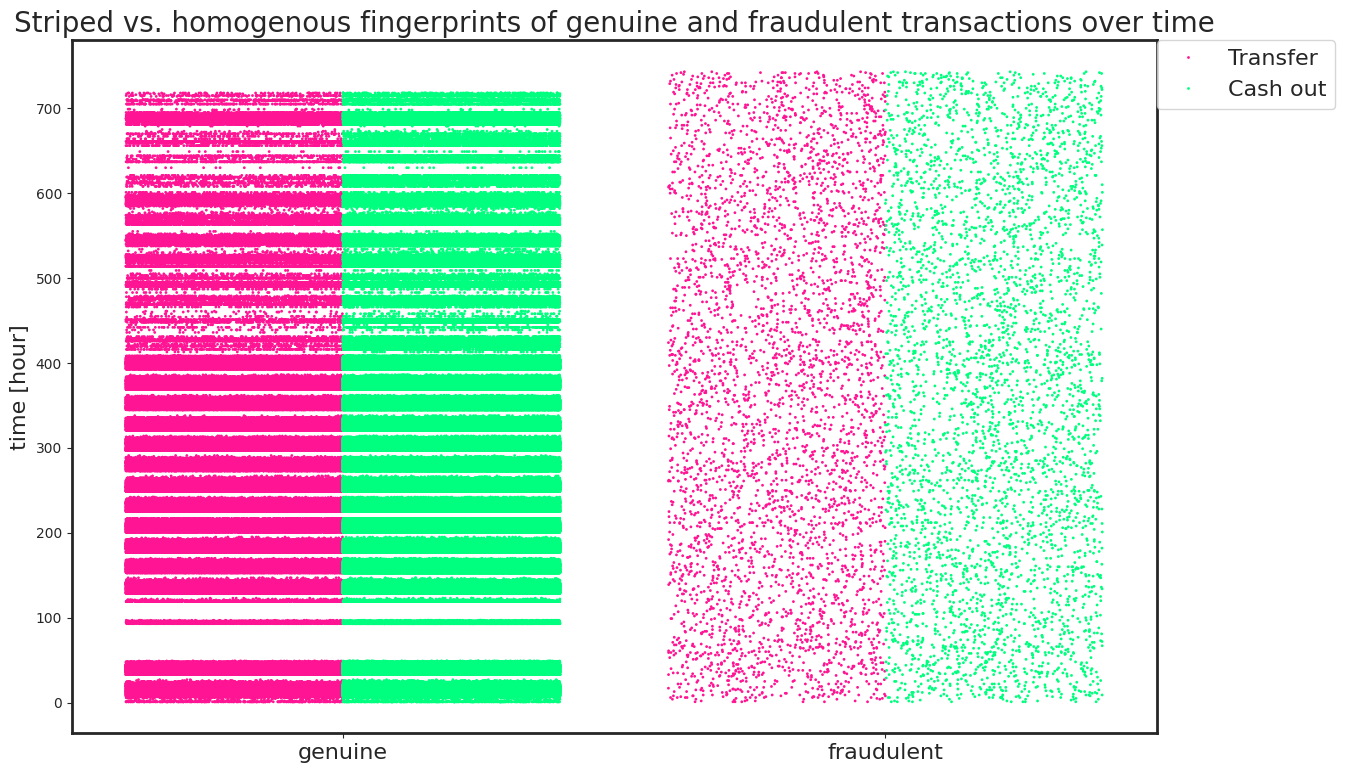

In [19]:
custom_palette = {0: "#ff1493", 1: "#00ff7f"}  # 0 → Pink, 1 → Green

limit = len(X)

if X['Type'].dtype != 'int':  
    X['Type'] = X['Type'].map({"TRANSFER": 0, "CASH_OUT": 1})  # Ensure numeric values

def plotStrip(x, y, hue, figsize=(14, 9)):
    fig = plt.figure(figsize=figsize)

    with sns.axes_style('ticks'):
        ax = sns.stripplot(x=x, y=y, hue=hue, jitter=0.4, marker='.', 
                           size=4, palette=custom_palette, dodge=True)  # 🎨 Apply fixed colors

        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size=16)
        
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)

        # ✅ Legend matches numeric encoding
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), 
                   loc=2, borderaxespad=0, fontsize=16)
    
    return ax

ax = plotStrip(x=Y[:limit], y=X['Step'][:limit], hue=X['Type'][:limit])
ax.set_ylabel('time [hour]', size=16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size=20)


This snippet **visualizes the distribution of genuine and fraudulent transactions** based on the **transaction amount** using a **strip plot**.

---

### Breakdown of the Code:
1. **Setting `limit`:**  
   - `limit = len(X)` → Uses all available data for visualization.

2. **Calling `plotStrip()`:**  
   - `Y[:limit]` → **X-axis:** Genuine (0) vs. Fraudulent (1) transactions.  
   - `X.Amount[:limit]` → **Y-axis:** Transaction amount.  
   - `X.Type[:limit]` → **Hue (Color):** Transfer (Pink) vs. Cash-out (Green).  
   - `figsize = (14, 9)` → Ensures a large, clear plot.

3. **Customizing Labels & Title:**  
   - `ax.set_ylabel('Amount', size=16)` → Labels Y-axis as "Amount".  
   - `ax.set_title(...)` → Highlights the goal: Identifying **patterns of fraud based on transaction amount**.

---

### Expected Insights from the Plot:
- **Are fraudulent transactions more likely to involve high amounts?**  
  - If fraud points **cluster at higher values**, fraudsters might be targeting **large transactions**.  
- **Are fraudulent transactions distributed evenly?**  
  - If fraud occurs at **all amounts**, detecting fraud based on transaction size alone might be difficult.  
- **Are there differences between `TRANSFER` and `CASH_OUT` fraud?**  
  - If cash-outs tend to have larger fraudulent amounts than transfers, it could suggest a specific fraud pattern.

/var/folders/m9/nwvp3yqj5f76trygypnkypv80000gp/T/ipykernel_32528/3592288029.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['genuine', 'fraudulent'], size=16)


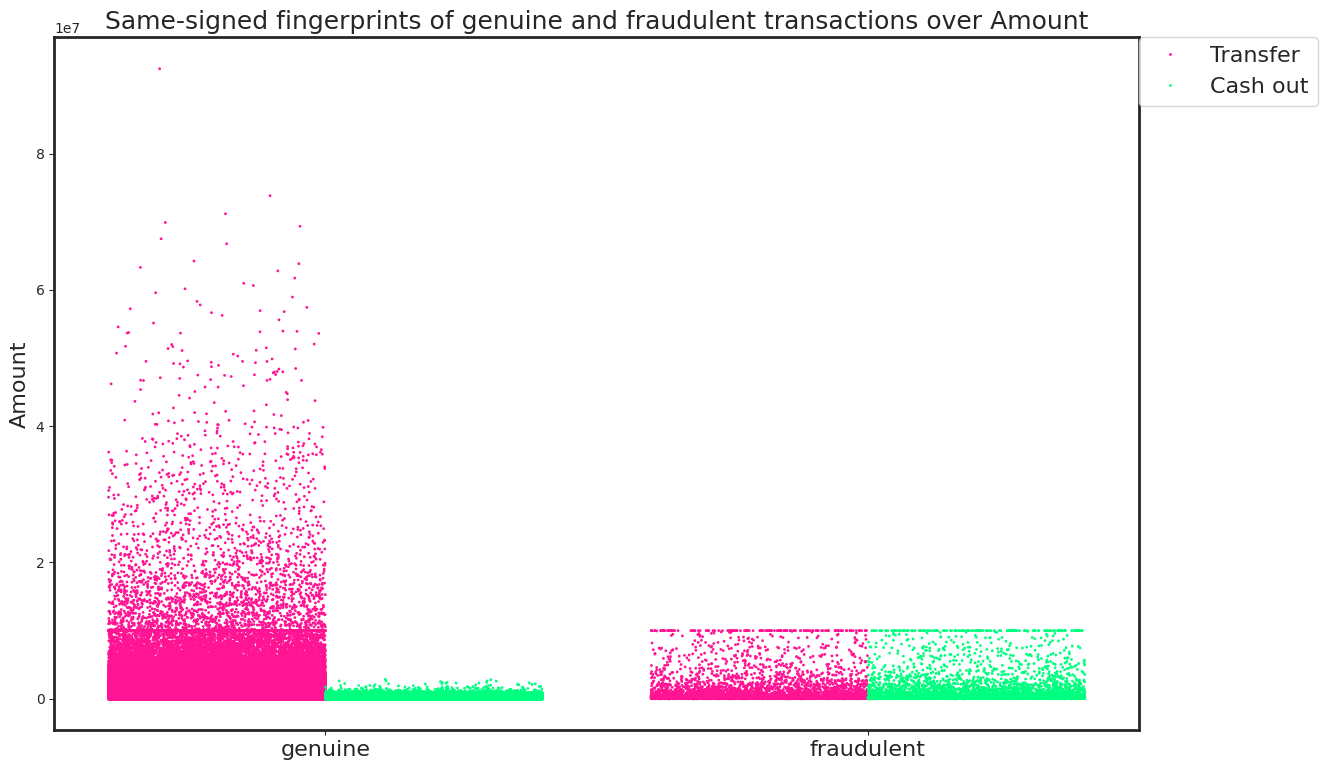

In [20]:
limit = len(X)
ax = plotStrip(Y[:limit], X.Amount[:limit], X.Type[:limit], figsize = (14, 9))
ax.set_ylabel('Amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over Amount', size = 18);

This code creates a **strip plot** to visualize how fraudulent and genuine transactions are distributed over time, with transaction types differentiated by color.

---

### Code Breakdown
1. **Custom Color Palette:**  
   - `0 → Pink ("#ff1493")` → **TRANSFER transactions**  
   - `1 → Green ("#00ff7f")` → **CASH_OUT transactions**  

2. **Ensuring `Type` is Numeric:**  
   - Converts `TRANSFER` → `0` and `CASH_OUT` → `1` if `X['Type']` is still categorical.

3. **Defining `plotStrip()` Function:**  
   - Uses `sns.stripplot()` to create a **jittered scatter plot**, separating transactions into:
     - **X-axis:** **Genuine (0) vs. Fraudulent (1)**  
     - **Y-axis:** **Transaction step (time in hours)**  
     - **Hue:** Transaction type (TRANSFER vs. CASH_OUT)  

   - Formatting Enhancements:
     - **Custom legend** (`TRANSFER` vs. `CASH_OUT`)
     - **Increased spine width** for a sharper plot
     - **Clear x-tick labels** (`'genuine'` and `'fraudulent'`)

4. **Plot Execution:**  
   - Calls `plotStrip()` with `x=Y`, `y=X['Step']`, and `hue=X['Type']`.  
   - Adds **labels and title** to indicate analysis over time.

---

### Expected Insights
- **Temporal Patterns in Fraudulent Transactions:**  
  - Are frauds happening **at specific times**, or are they **spread out evenly**?
- **Fraud Trends in Transaction Types:**  
  - Do **TRANSFER** and **CASH_OUT** frauds follow **different time patterns**?
- **Comparison to Genuine Transactions:**  
  - Are frauds **clustered** in a way that distinguishes them from genuine ones?

/var/folders/m9/nwvp3yqj5f76trygypnkypv80000gp/T/ipykernel_32528/3592288029.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['genuine', 'fraudulent'], size=16)


Text(0.5, 1.0, 'Striped vs. homogenous fingerprints of genuine and fraudulent transactions over time')

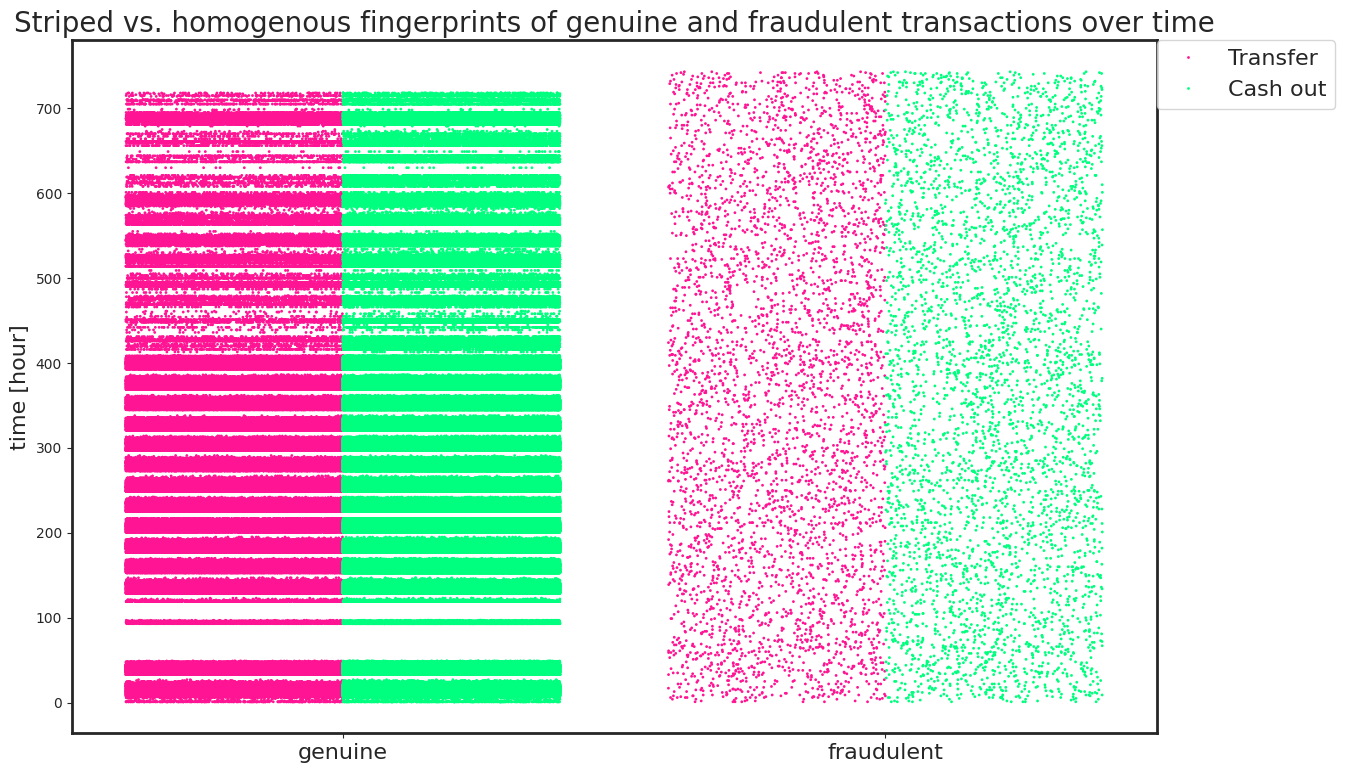

In [ ]:
custom_palette = {0: "#ff1493", 1: "#00ff7f"}  # 0 → Pink, 1 → Green

limit = len(X)

if X['Type'].dtype != 'int':  
    X['Type'] = X['Type'].map({"TRANSFER": 0, "CASH_OUT": 1})  # Ensure numeric values

def plotStrip(x, y, hue, figsize=(14, 9)):
    fig = plt.figure(figsize=figsize)

    with sns.axes_style('ticks'):
        ax = sns.stripplot(x=x, y=y, hue=hue, jitter=0.4, marker='.', 
                           size=4, palette=custom_palette, dodge=True)  # Apply fixed colors

        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size=16)
        
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)

        # Legend matches numeric encoding
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), 
                   loc=2, borderaxespad=0, fontsize=16)
    
    return ax

ax = plotStrip(x=Y[:limit], y=X['Step'][:limit], hue=X['Type'][:limit])
ax.set_ylabel('time [hour]', size=16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size=20)


### What This Code Does
This code generates a **strip plot** to visualize how the **error in destination account balances (`errorBalanceDest`)** differs between **fraudulent** and **genuine** transactions, with transaction types (`TRANSFER` vs. `CASH_OUT`) color-coded.

---

### Breakdown
1. **Negative Transformation (`- errorBalanceDest`)**
   - Instead of plotting `errorBalanceDest`, the negative values (`-X.errorBalanceDest`) are plotted.
   - This effectively **flips the y-axis**, potentially revealing clearer separation in fraud patterns.

2. **Using `plotStrip()`**
   - **X-axis:** Fraudulent vs. Genuine (`Y[:limit]`)
   - **Y-axis:** `- errorBalanceDest`
   - **Hue:** Transaction Type (`TRANSFER` vs. `CASH_OUT`)
   - **Figure Size:** `(14,9)`

3. **Labels and Titles**
   - **Y-label:** `'- errorBalanceDest'`
   - **Title:** `"Opposite polarity fingerprints over the error in destination account balances"`  
     - This suggests the intention is to **analyze fraud patterns based on balance errors**.

---

### Expected Insights
- **Do frauds tend to have distinct balance errors compared to genuine transactions?**  
  - If so, this could help detect fraud **based on balance discrepancies**.
- **Are there specific transaction types (`TRANSFER` vs. `CASH_OUT`) that exhibit more pronounced balance errors in fraud?**
- **Does flipping the error balance (`-errorBalanceDest`) reveal clearer separations?**
  - If fraudulent transactions cluster differently after flipping, **polarity may be a key differentiator**.

/var/folders/m9/nwvp3yqj5f76trygypnkypv80000gp/T/ipykernel_32528/3592288029.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['genuine', 'fraudulent'], size=16)


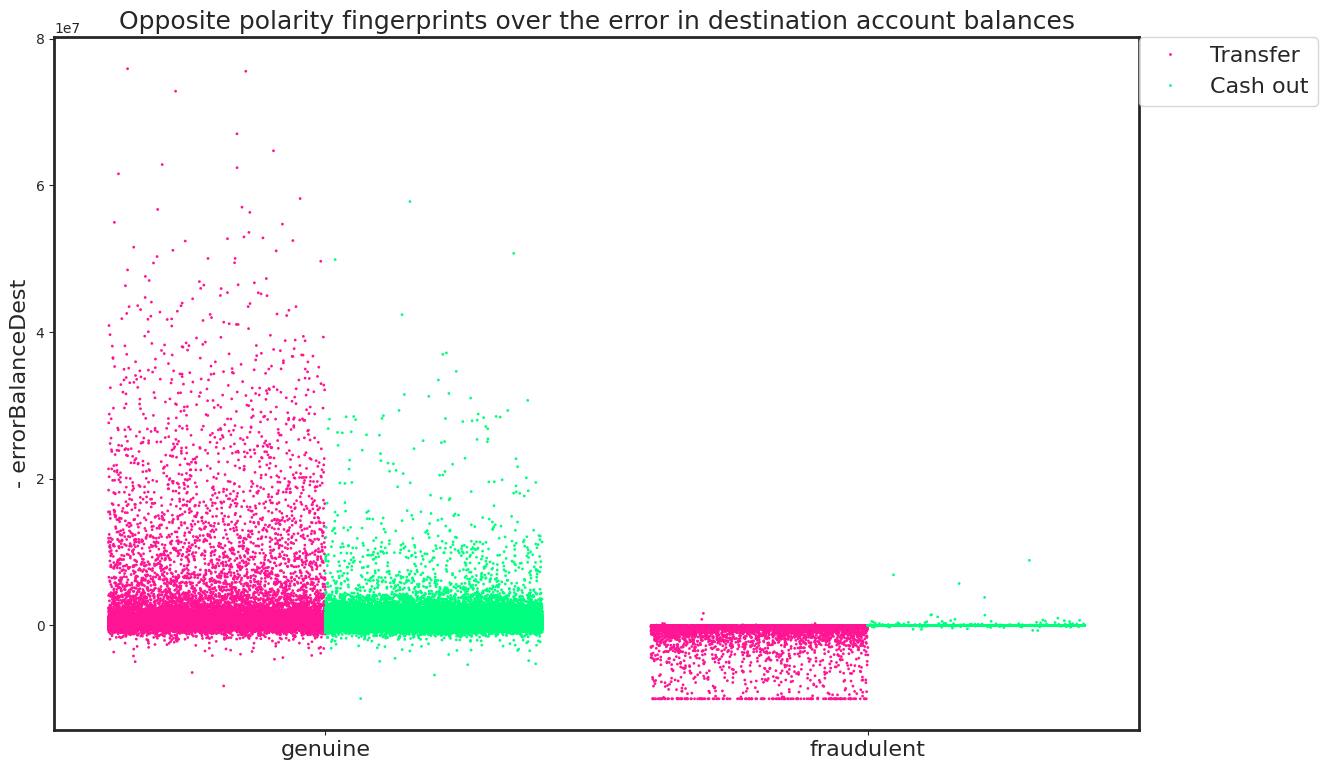

In [21]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.Type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

### What This Code Does
This code generates a **3D scatter plot** to visualize how error-based features (`errorBalanceDest`, `errorBalanceOrig`) evolve over time (`Step`) in **fraudulent vs. genuine transactions**.

---

### Breakdown
1. **Axes Definitions**
   - **X-axis (`errorBalanceDest`)** → The error in the destination account's balance.
   - **Y-axis (`Step`)** → The transaction time step (in hours).
   - **Z-axis (`-log10(errorBalanceOrig)`)** → The transformed error in the originating account's balance.
   - **zOffset (`0.02`)** → A small constant added to prevent log transformation errors when `errorBalanceOrig` is zero.

2. **3D Scatter Plot**
   - Uses `plt.figure()` with a 3D projection.
   - **Green Dots (`c='g'`)** → Represent **genuine** transactions.
   - **Red Dots (`c='r'`)** → Represent **fraudulent** transactions.
   - **Small marker size (`s=1`)** → Ensures clarity in high-density areas.

3. **Log Transformation**
   - `-np.log10(X.loc[Y == 0, z][:limit] + zOffset)`
   - The negative sign inverts the log scale, potentially improving visualization.

4. **Labels & Titles**
   - **X-label**: `'errorBalanceDest'`
   - **Y-label**: `'Step [hour]'`
   - **Z-label**: `'- log$_{10}$(errorBalanceOrig)'`
   - **Title**: `'Error-based features separate out genuine and fraudulent transactions'`

5. **Legend**
   - Custom **green** and **red** markers for fraud detection clarity.
   - Legend positioned outside (`bbox_to_anchor=(1.20, 0.38)`).

---

### Expected Insights
- **Are fraudulent transactions clearly separable from genuine ones based on balance errors?**  
  - If fraud data clusters differently, **balance discrepancies may be strong fraud indicators**.
- **How does the error behavior change over time (`Step`)?**
  - If fraudulent transactions **peak at specific times**, this could be useful for real-time monitoring.
- **Why use log transformation?**
  - Some transactions might have extreme `errorBalanceOrig` values. Log scaling **reduces skewness**, making clusters more visible.

/usr/local/Caskroom/miniconda/base/envs/UCB/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/Caskroom/miniconda/base/envs/UCB/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


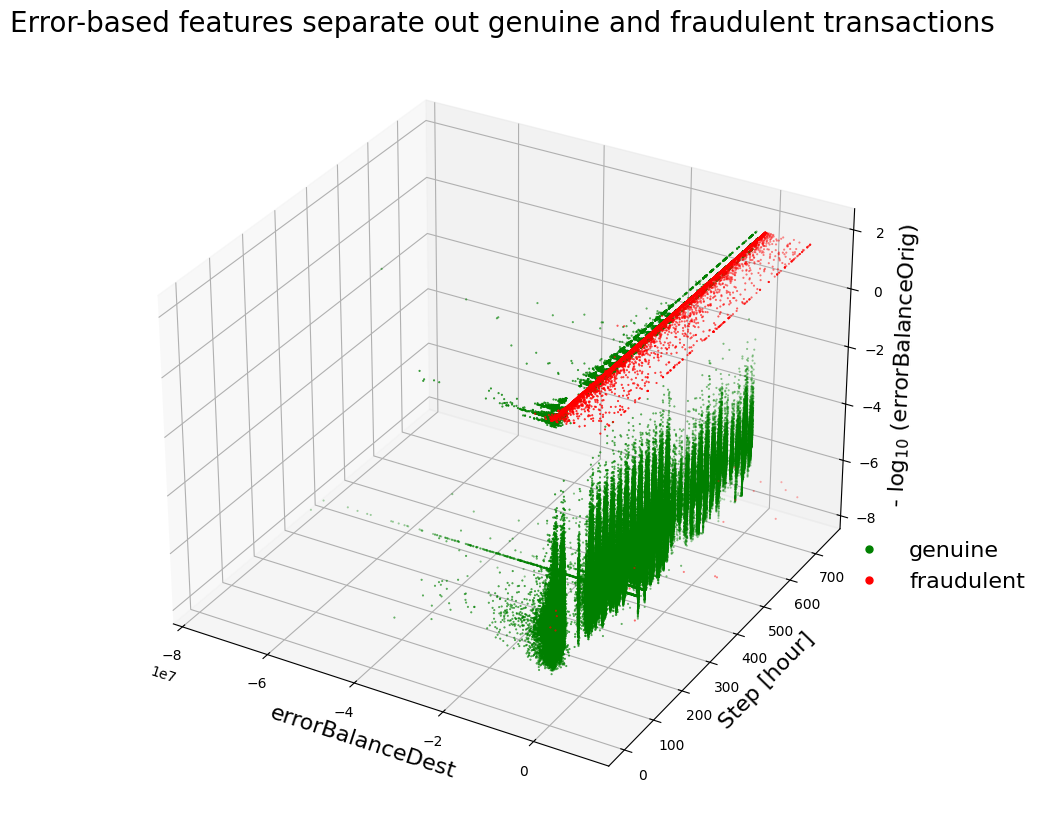

In [22]:
x = 'errorBalanceDest'
y = 'Step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() \

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

### What This Code Does
This code creates **correlation heatmaps** for **genuine** and **fraudulent** transactions separately, helping to analyze how features interact differently in both cases.  

---

### Breakdown
1. **Separate Genuine & Fraudulent Transactions**  
   ```python
   Xfraud = X.loc[Y == 1]  
   XnonFraud = X.loc[Y == 0]
   ```
   - `Xfraud` → Contains only fraudulent transactions.
   - `XnonFraud` → Contains only genuine transactions.

2. **Compute Correlation Matrices**  
   ```python
   correlationNonFraud = XnonFraud.loc[:, X.columns != 'Step'].corr()
   correlationFraud = Xfraud.loc[:, X.columns != 'Step'].corr()
   ```
   - `.corr()` computes Pearson correlation coefficients between numerical features.
   - **Step** is excluded as it's likely a time variable.

3. **Create a Mask for the Heatmap**  
   ```python
   mask = np.zeros_like(correlationNonFraud)
   indices = np.triu_indices_from(correlationNonFraud)
   mask[indices] = True
   ```
   - A **triangular mask** ensures that only the **lower-triangle** is displayed, avoiding redundancy.

4. **Set Up Subplots with a Color Bar**  
   ```python
   grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
   f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, figsize=(14, 9))
   ```
   - `ax1` → **Genuine transactions** heatmap.
   - `ax2` → **Fraudulent transactions** heatmap.
   - `cbar_ax` → Color bar axis.

5. **Plot Heatmaps**
   ```python
   cmap = sns.diverging_palette(220, 8, as_cmap=True)
   ```
   - `diverging_palette(220, 8)` → Creates a color gradient where negative correlations are **blue**, positive are **red**.

   **Heatmap for Genuine Transactions**
   ```python
   ax1 = sns.heatmap(correlationNonFraud, ax=ax1, vmin=-1, vmax=1, 
       cmap=cmap, square=False, linewidths=0.5, mask=mask, cbar=False)
   ```
   - Displays correlations **only for genuine transactions**.

   **Heatmap for Fraudulent Transactions**
   ```python
   ax2 = sns.heatmap(correlationFraud, vmin=-1, vmax=1, cmap=cmap,
       ax=ax2, square=False, linewidths=0.5, mask=mask, yticklabels=False,
       cbar_ax=cbar_ax, cbar_kws={'orientation': 'vertical',
                                  'ticks': [-1, -0.5, 0, 0.5, 1]})
   ```
   - Displays correlations **only for fraudulent transactions**.
   - Shares the **color bar** (`cbar_ax`) to maintain uniformity.

6. **Final Touches**
   ```python
   ax1.set_title('Genuine \n transactions', size=20)
   ax2.set_title('Fraudulent \n transactions', size=20)
   ```
   - Adds **titles** to distinguish between genuine and fraudulent transactions.

   ```python
   cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size=14)
   ```
   - Ensures color bar labels are readable.

---

### Expected Insights
1. **Which features are strongly correlated in fraud vs. genuine transactions?**  
   - If a feature (e.g., `errorBalanceDest`) is **highly correlated with another** in fraudulent transactions but not in genuine ones, it might indicate fraud patterns.
   
2. **Do certain correlations flip between fraud & genuine cases?**  
   - If a **positive correlation turns negative**, fraudsters might be **exploiting a loophole** in transactions.

3. **Are fraudulent transactions more structured?**  
   - If fraudulent transactions show **stronger correlations**, fraudsters might follow **predictable strategies**.

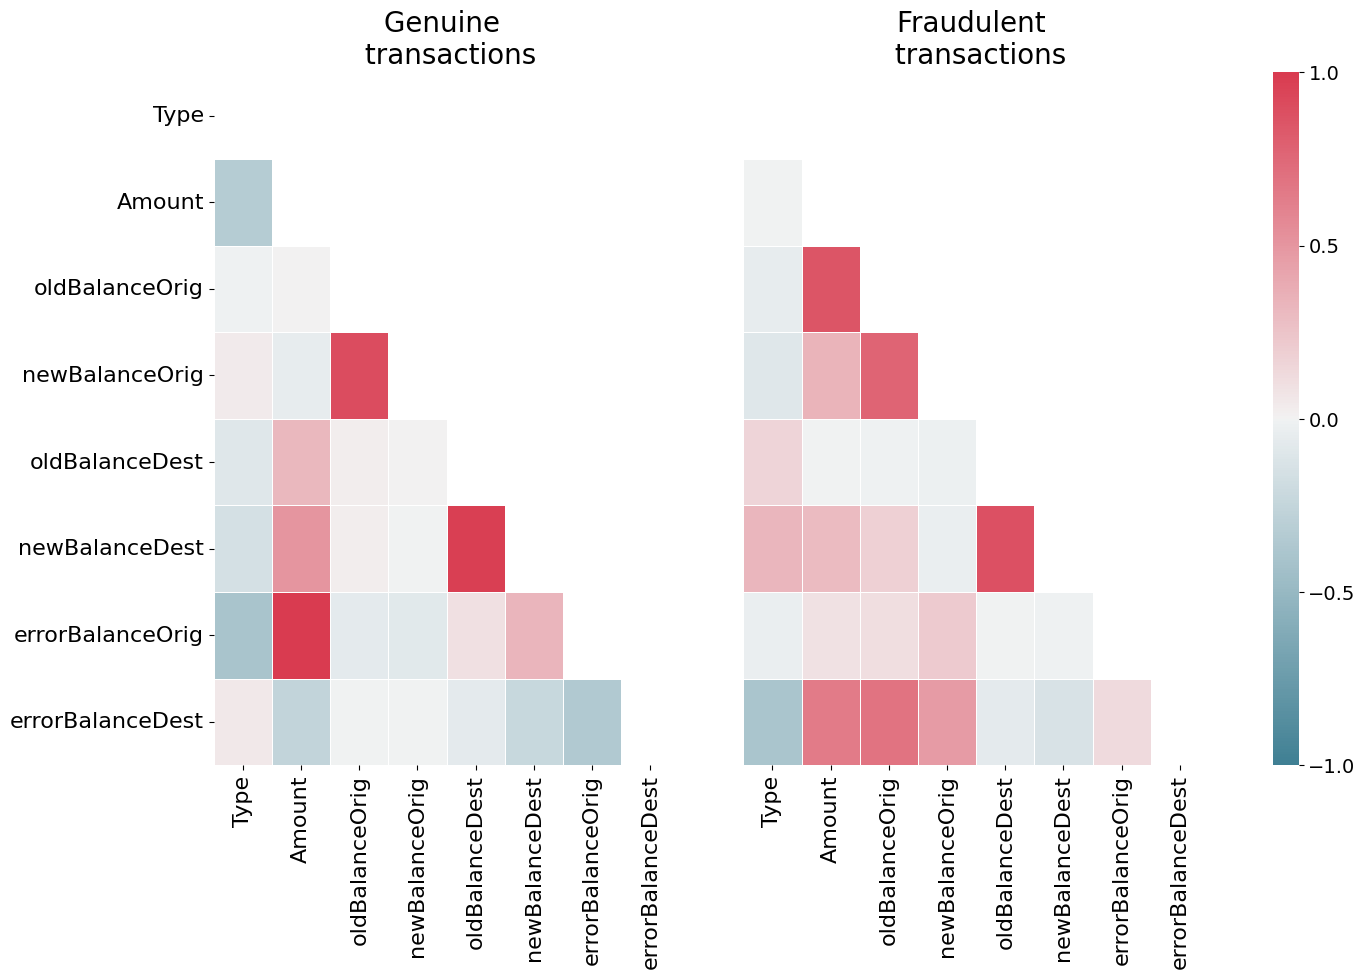

In [23]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'Step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'Step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

### What This Code Does
```python
print('skew = {}'.format(len(Xfraud) / float(len(X))))
```
This calculates the **imbalance (skew)** of fraudulent transactions in the dataset.

---

### Breakdown
1. **`len(Xfraud)`** → Counts the number of fraudulent transactions (`Y == 1`).
2. **`len(X)`** → Counts the total number of transactions.
3. **`len(Xfraud) / float(len(X))`** → Computes the **ratio of fraudulent transactions** in the dataset.
4. **`print()`** → Displays the skew value.

---

### Why This Matters?
- If the skew is **very low** (e.g., `0.01` or **1% fraud**), your dataset is **highly imbalanced**.
- Imbalanced datasets can **bias machine learning models**, making them **favor the majority class (genuine transactions).**
- You might need **oversampling (SMOTE) or undersampling** to balance the classes.


In [24]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


### What This Code Does
```python
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=randomState)
```
This splits the dataset into **training** and **testing** sets.

---

### Breakdown
1. **`train_test_split()`**:
   - `X` → Features (independent variables).
   - `Y` → Target labels (fraud or genuine).
   - `test_size=0.2` → **20% of the data** is reserved for testing, while **80%** is used for training.
   - `random_state=randomState` → Ensures reproducibility (same split every time).

2. **Outputs**:
   - `trainX`: Features for training.
   - `testX`: Features for testing.
   - `trainY`: Labels for training.
   - `testY`: Labels for testing.

---

### Why This Matters?
- Ensures **model generalization** by testing on unseen data.
- Helps prevent **overfitting** (where the model memorizes training data).
- The **`random_state`** ensures **consistent results** when rerunning experiments.

In [25]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

### What This Code Does
This code trains an **XGBoost Classifier** on the dataset while handling class imbalance and evaluates it using **Average Precision Score (AUPRC)**.

---

### Breakdown
1. **Handle Class Imbalance**:
   ```python
   weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
   ```
   - Calculates the **ratio of genuine (0) to fraudulent (1) transactions**.
   - This is used to **scale the positive class (fraud cases)**.

2. **Initialize XGBoost Classifier**:
   ```python
   clf = XGBClassifier(max_depth=3, scale_pos_weight=weights, n_jobs=4)
   ```
   - `max_depth=3`: Limits tree depth to prevent **overfitting**.
   - `scale_pos_weight=weights`: Adjusts the weight of the minority class (fraud) for **better handling of class imbalance**.
   - `n_jobs=4`: Uses **4 CPU cores** for faster training.

3. **Train and Predict**:
   ```python
   probabilities = clf.fit(trainX, trainY).predict_proba(testX)
   ```
   - **Fits the model** using training data (`trainX`, `trainY`).
   - Predicts **probabilities** for the test data.

4. **Evaluate Model (AUPRC)**:
   ```python
   print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))
   ```
   - `average_precision_score()` computes the **Area Under the Precision-Recall Curve (AUPRC)**.
   - **Why AUPRC?** → It’s **better than ROC-AUC** for imbalanced datasets because it focuses on **precision and recall** rather than just true/false positives.

In [26]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

AUPRC = 0.9926360768575739


This code visualizes the **feature importance** in the trained XGBoost model based on the **cover metric**, which represents how many times a feature is used in the trees.  

---

### Breakdown
1. **Create Figure and Axes**:
   ```python
   fig = plt.figure(figsize=(14, 9))
   ax = fig.add_subplot(111)
   ```
   - Defines a **figure** and a subplot.

2. **Define Colors**:
   ```python
   colours = plt.cm.Set1(np.linspace(0, 1, 9))
   ```
   - Uses the **Set1 color map** for distinct feature colors.

3. **Plot Feature Importance**:
   ```python
   ax = plot_importance(clf, height=1, color=colours, grid=False, \
                        show_values=False, importance_type='cover', ax=ax)
   ```
   - **`plot_importance(clf)`**: Plots feature importance from the trained `clf` model.
   - **`importance_type='cover'`**: Measures feature importance by how often a feature is used in the trees.
   - **Disables grid and value display** for a cleaner visualization.

4. **Format Plot**:
   ```python
   for axis in ['top', 'bottom', 'left', 'right']:
       ax.spines[axis].set_linewidth(2)
   ```
   - Sets the **border width** of the plot.

5. **Label Axes and Title**:
   ```python
   ax.set_xlabel('importance score', size=16)
   ax.set_ylabel('features', size=16)
   ax.set_yticklabels(ax.get_yticklabels(), size=12)
   ax.set_title('Ordering of features by importance to the model learnt', size=20)
   ```
   - Adds **labels** and a **title** to improve readability.

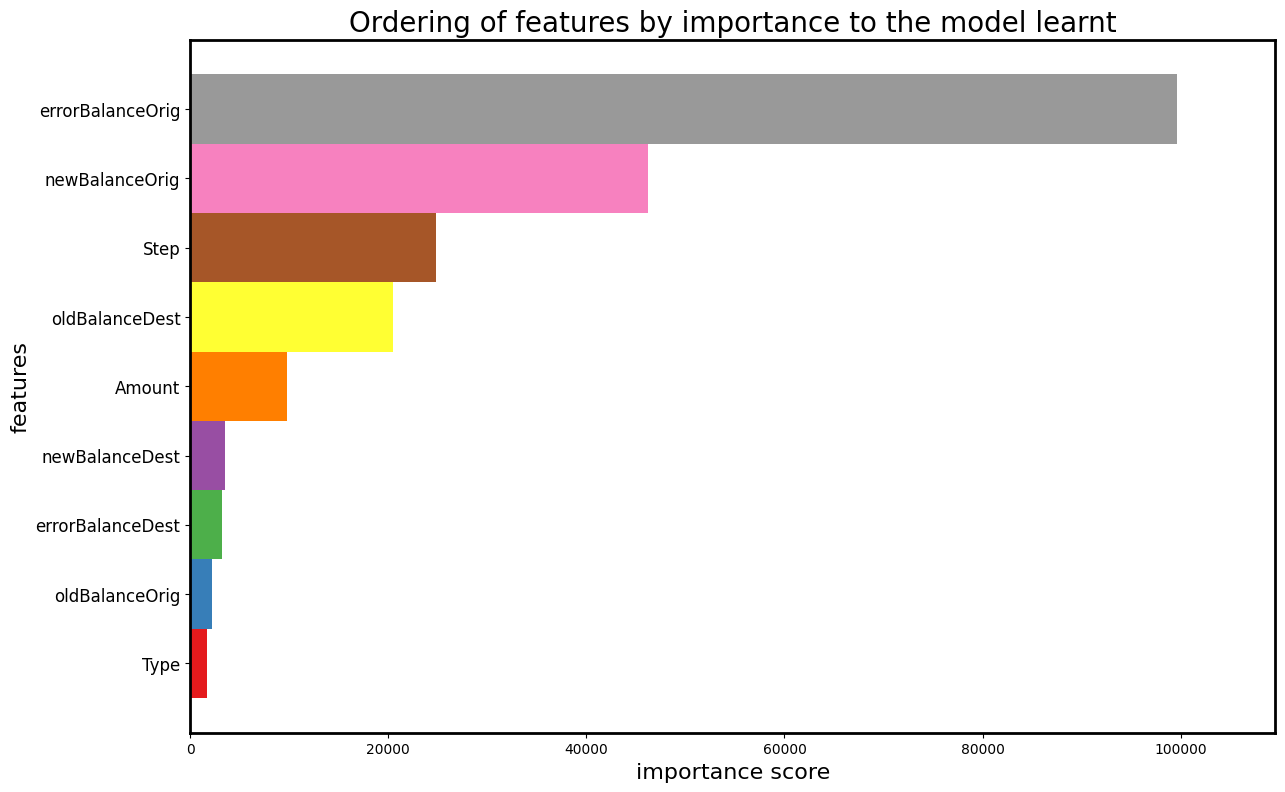

In [27]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

`to_graphviz(clf)` generates a visual representation of the trained **XGBoost** model as a decision tree. If you want to display or save the visualization, you may need to modify the command slightly.  

###  Example Usage
#### 1. Display the Tree Inline (Jupyter Notebook)
```python
from xgboost import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))
plot_tree(clf, num_trees=0)  # Visualize the first tree
plt.show()
```
- This will render the first tree in the **XGBoost ensemble**.

#### 2. Export to Graphviz Format
If you want a **Graphviz dot format** for more detailed visualization:  
```python
from xgboost import to_graphviz

dot_data = to_graphviz(clf, num_trees=0)
dot_data.view()  # Opens in Graphviz viewer
```
- `.view()` **opens the visualization** in the default Graphviz application.

#### 3. Save as a File (Optional)
If you need to save it as a `.dot` file:
```python
dot_data.render("xgboost_tree")
```
- This creates a file `xgboost_tree.pdf` or `xgboost_tree.png`.

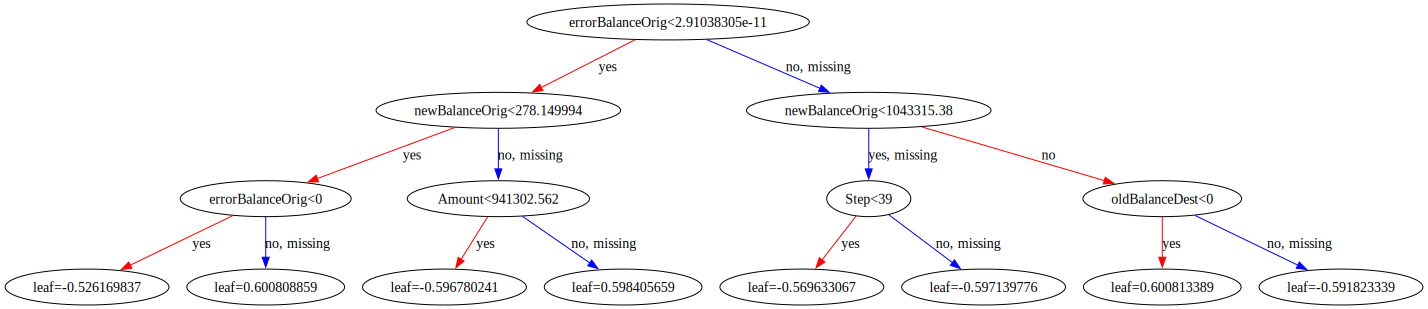

In [28]:
to_graphviz(clf)

In [29]:
trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX,\
                                         trainY, scoring = 'average_precision')

This code is generating a learning curve plot that visualizes how the model's performance changes as the training set size increases. It includes training and cross-validation scores, confidence intervals, and formatting for clarity.  

### **Possible Improvements:**
1. **Fix `plt.xlim(0.2e6, 1e6)` & `plt.ylim(0.98, 1)`**  
   - Ensure your dataset size and AUPRC scores actually fall within this range. Adjust if needed.
   
2. **Use `np.linspace` in `trainSizes` if not defined**  
   - If `trainSizes` is undefined, generate it using:
     ```python
     trainSizes = np.linspace(len(trainX) * 0.1, len(trainX), num=len(trainScores))
     ```

3. **Improve Labeling & Legend Placement**  
   - Adjust `bbox_to_anchor` to prevent overlapping.

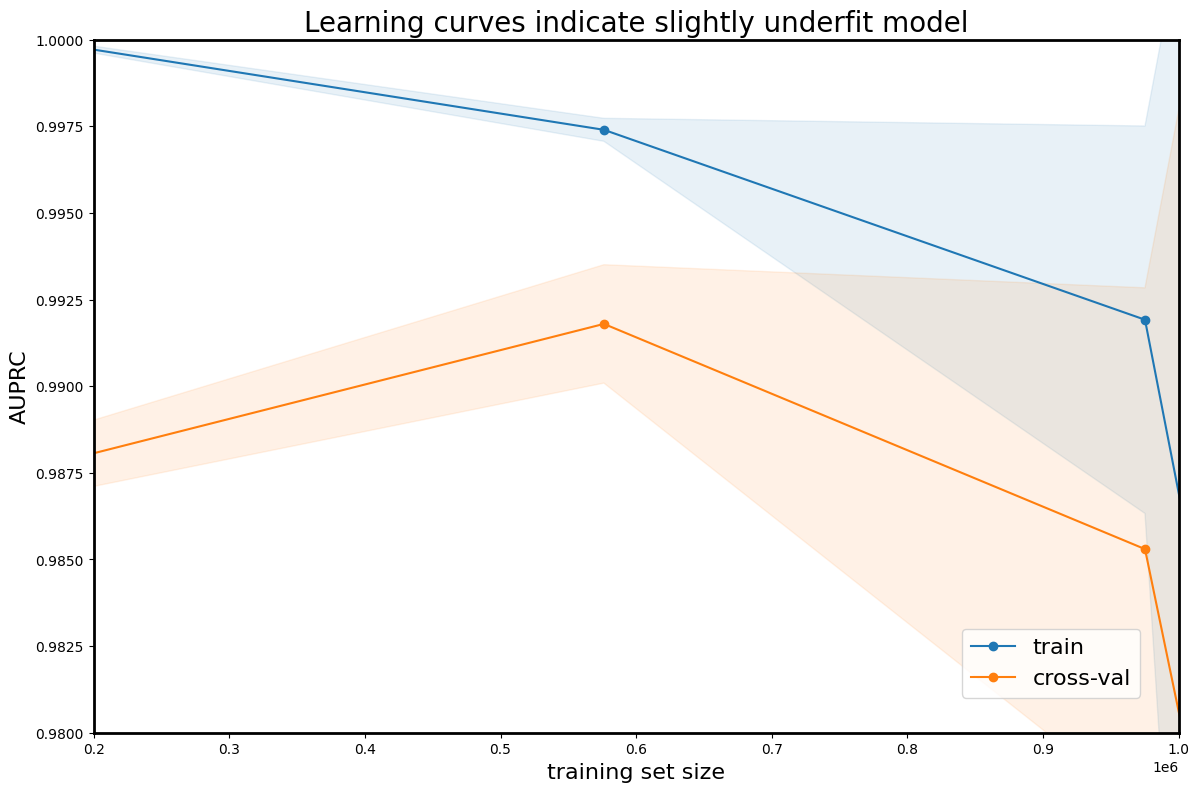

In [30]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

plt.xlim(0.2e6, 1e6)
plt.ylim(0.98, 1)

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16)

plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);